# Run Variant List Optimizer

In [1]:
import sys

import ray
from ray.job_config import JobConfig
from scipy.stats import zscore


import pandas as pd

In [2]:
num_cpus = 35 # usable cpus on BII nodes on rivanna

In [3]:
code_dir = "/project/bii_nssac/people/bl4zc/variant-list-optimizer"

sys.path.append(code_dir)
ray.init(job_config=JobConfig(code_search_path=[code_dir]))

2024-05-22 10:53:58,951	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.4
Ray version:,2.11.0
Dashboard:,http://127.0.0.1:8265


In [4]:
from variant_list_optimizer import *

In [5]:
oi_fname = "/project/nssac_covid19/COVID-19_commons/products/external_data_collection/variants/outbreak_info_variants_states_long.csv"

In [6]:
usecols = ["date", "lineage", "fips", "lineage_count"]
parse_dates = ["date"]

oi_df = pd.read_csv(oi_fname, usecols=usecols, parse_dates=parse_dates, low_memory=False)
oi_df = oi_df.rename(columns={
    "lineage": "variant",
    "lineage_count": "weight"
})

oi_df = oi_df.dropna(subset=["date", "variant"])

In [7]:
print("Max date of this data is:",oi_df.date.max())
oi_df.sample(10)

Max date of this data is: 2024-05-13 00:00:00


,weight,date,variant,fips
693956,1,2023-07-13,XBB.1.5,47
1006330,1,2024-01-12,JN.1.1.1,US
44269,15,2021-12-21,AY.117,06
785553,1,2023-01-17,CH.1.1.1,51
546810,9,2022-12-20,BQ.1.3.2,36
403173,1,2021-09-25,AY.122,27
759210,1,2023-10-16,GJ.1.2.4,49
519953,7,2021-09-22,AY.39.1,36
708661,15,2021-12-29,BA.1.18,48
941874,1,2022-07-01,BF.12,US


In [8]:
def find_the_list(data,date,size):
    
    print("Finding list:",date,size)
    ref_time = pd.to_datetime(date)
    data = data[data.date < ref_time]
    
    time_importance = get_time_importance(1.0, 0.1)
    distance_badness = get_distance_badness(1.0, 10.0)
    
    tree = make_variant_tree(data, ref_time, time_importance)
    pruned_tree = prune_tree(tree)

    print(date,"finding list",size,"on a tree size",pruned_tree.number_of_nodes())
    
    beam_opt = optimize_beam_search(size, size, pruned_tree, distance_badness, par=num_cpus)
    
    v_nia = make_nearest_included_ancestor(beam_opt, tree, distance_badness)
    beam_badness = sum(nia.badness for nia in v_nia.values())
    print(date,"Badness:",beam_badness)
    
    df = pd.DataFrame(list(beam_opt),columns=[date])
    return df
    

In [9]:
data = oi_df[oi_df.fips.isin(["42", "54", "51", "10", "24"])]
counts_data = data[["date", "variant", "weight"]]

In [10]:
## Sum all samples across states
data = data.groupby(['date','variant']).weight.sum().reset_index()

In [11]:
data.shape

(45907, 3)

In [12]:
data.sample(10)

,date,variant,weight
35472,2023-02-18,XBB.1.5.10,1
41549,2023-10-05,XBB.1.16.11,2
41205,2023-09-26,XCH.1,1
36232,2023-03-12,XBB.1.5.17,1
14498,2022-01-06,BA.1.22,2
32111,2022-12-27,XBB.1.5.52,2
12344,2021-11-12,AY.34,3
22480,2022-08-18,BA.4.1.8,1
36240,2023-03-13,B.1.1,1
32005,2022-12-26,EE.1,4


In [13]:
## calculate a the slope difference
diff_df = data.pivot(columns = 'variant', index='date', values = 'weight')
## this takes a 3 week rolling sum
diff_df = diff_df.resample('W').sum().rolling(3).sum().diff(2)
df = diff_df.reset_index().melt(id_vars='date',value_name = 'weight')
df.dropna(inplace = True)
two_week_diff = df
two_week_diff[two_week_diff.weight != 0].sample(10)

,date,variant,weight
224770,2023-01-15,FD.4,-1.0
31119,2022-01-23,B.1,-2.0
369763,2023-04-16,XBB.1.5.7,3.0
366010,2023-01-15,XBB.1.5.52,6.0
277580,2023-03-26,HJ.1,-2.0
332921,2021-05-02,P.3,1.0
35025,2021-01-10,B.1.1.265,15.0
110803,2022-11-27,BA.5.2.23,3.0
322053,2023-11-12,JR.1.1,5.0
46451,2020-10-04,B.1.311,-2.0


<Axes: >

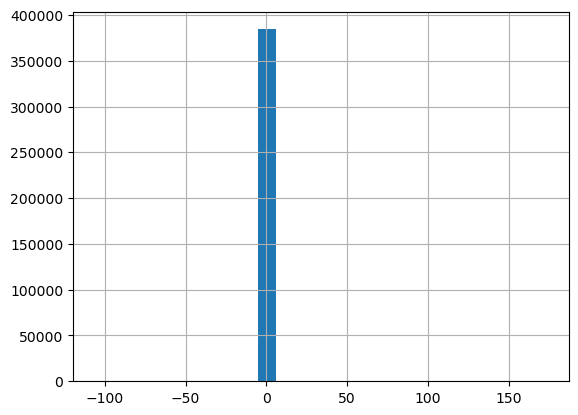

In [23]:
two_week_diff['weight_zscore'] = (two_week_diff['weight'] - two_week_diff['weight'].mean()) / two_week_diff['weight'].std()
two_week_diff['weight_zscore'].hist(bins=25)

In [60]:
#data = df

,weight,date,variant,fips
172813,1,2020-03-19,A,10
172814,1,2020-03-30,A,10
172815,1,2020-03-20,A.1,10
172816,1,2021-04-28,A.2.5,10
172817,1,2021-03-23,A.2.5.1,10
...,...,...,...,...
821414,1,2022-05-09,XY,54
821415,1,2022-05-13,XY,54
821416,1,2022-05-24,XY,54
821417,1,2022-06-06,XY,54


## Loop over dates to calculate lists

In [ ]:
## Dates of interest
dates_to_calculate = ["2021-12-01","2021-12-15","2021-12-31","2022-04-23","2022-12-03"]

## prepped dataframe to use for the calculation
data = two_week_diff


for date in dates_to_calculate:
    l = find_the_list(data,date,15)
    if date == dates_to_calculate[0]:
        lists = l
    else:
        lists = pd.concat([lists,l],axis=1)
    

Finding list: 2021-12-01 15
2021-12-01 finding list 15 on a tree size 94
cur_size=2
cur_size=3
cur_size=4
cur_size=5
cur_size=6
cur_size=7
cur_size=8
cur_size=9
cur_size=10
cur_size=11
cur_size=12
cur_size=13
cur_size=14
cur_size=15
2021-12-01 Badness: -403318.7496542954
Finding list: 2021-12-15 15
2021-12-15 finding list 15 on a tree size 104
cur_size=2
cur_size=3
cur_size=4
cur_size=5
cur_size=6
cur_size=7
cur_size=8
cur_size=9
cur_size=10
cur_size=11
cur_size=12
cur_size=13
cur_size=14
cur_size=15
2021-12-15 Badness: -300274.08197907486
Finding list: 2021-12-31 15


In [106]:
lists

,2021-12-01,2021-12-15,2021-12-31,2022-04-23,2022-12-03
0,AY.120,AY.120,AY.34.1,BA.2.23,BF.7
1,AY.121,AY.121,BA.1.15,SARS-CoV-2,DJ.1.1.1
2,AY.103,AY.103,AY.103,BA.2,BE.4.2
3,AY.43,AY.43,AY.4.5,BA.2.37,SARS-CoV-2
4,AY.39,SARS-CoV-2,SARS-CoV-2,BA.2.7,BA.5.2.34
5,SARS-CoV-2,AY.39,BA.1.18,BA.2.12.1,BA.5.2.24
6,AY.34,AY.34,AY.46.4,BA.1.1.4,CQ.2
7,BA.1,BA.1,AY.4.2,BA.2.9,BE.1.2.1
8,AY.3.3,AY.100,BA.1,BA.2.18,BQ.1
9,AY.4,AY.4,AY.39.1,BA.2.3,BA.5.2.6


In [70]:
##not_combined = lists
combined = lists
lists

,2021-12-01,2021-12-15,2021-12-31,2022-04-23,2022-12-03
0,AY.122,AY.122,BA.1.15,BA.1.15,BA.4.6
1,AY.3,B.1,AY.103,AY.103,BA.5
2,AY.103,AY.103,B.1,SARS-CoV-2,BQ.1.1
3,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,BA.2.12.1,SARS-CoV-2
4,AY.39,AY.39,AY.39,BA.1.18,BA.2
5,AY.25.1,AY.25.1,AY.25.1,BA.2,BA.2.75
6,AY.47,BA.1,BA.1.18,BA.2.7,BA.5.2.1
7,AY.100,AY.4,BA.1,BA.1.1.18,BN.1
8,AY.44,AY.100,AY.100,BA.2.9,BQ.1
9,AY.119,AY.119,AY.119,BA.1,CH.1.1


In [71]:
not_combined.compare(combined)

2021-12-01         2021-12-15         2021-12-31          2022-04-23  \
         self   other       self   other       self    other       self   
1         NaN     NaN     AY.103     B.1        NaN      NaN        NaN   
2         NaN     NaN        B.1  AY.103        NaN      NaN        NaN   
3         NaN     NaN        NaN     NaN        NaN      NaN    BA.1.18   
4         NaN     NaN        NaN     NaN        NaN      NaN  BA.1.1.18   
5         NaN     NaN        NaN     NaN    BA.1.18  AY.25.1     BA.2.7   
6         NaN     NaN        NaN     NaN    AY.25.1  BA.1.18  BA.2.12.1   
7         NaN     NaN     AY.100    AY.4        NaN      NaN       BA.2   
8      AY.119   AY.44       AY.4  AY.100        NaN      NaN        NaN   
9       AY.44  AY.119        NaN     NaN      AY.44   AY.119        NaN   
10        NaN     NaN        NaN     NaN     AY.119    AY.44        NaN   
11        NaN     NaN        NaN     NaN        NaN      NaN        NaN   
12        NaN     NaN        NaN     NaN        NaN      NaN        NaN   
13        NaN     NaN        NaN     NaN        NaN      NaN        NaN   

               2022-12-03              
        other        self       other  
1         NaN         NaN         NaN  
2         NaN  SARS-CoV-2      BQ.1.1  
3   BA.2.12.1      BQ.1.1  SARS-CoV-2  
4     BA.1.18         NaN         NaN  
5        BA.2    BA.5.2.1     BA.2.75  
6      BA.2.7        BN.1    BA.5.2.1  
7   BA.1.1.18        BQ.1        BN.1  
8         NaN       XBB.1        BQ.1  
9         NaN         NaN         NaN  
10        NaN      BA.5.2       XBB.1  
11        NaN      BA.5.1      BA.5.2  
12        NaN   B.1.1.529      BA.5.1  
13        NaN     BA.2.75   B.1.1.529

###  PB's original prep and runs

In [9]:
ref_time = pd.to_datetime("2024-03-01")

In [10]:
data = data[data.date < ref_time]

In [11]:
time_importance = get_time_importance(1.0, 0.1)
distance_badness = get_distance_badness(1.0, 10.0)

In [12]:
tree = make_variant_tree(data, ref_time, time_importance)

In [13]:
tree.number_of_edges(), tree.number_of_nodes()

(1896, 1897)

In [14]:
pruned_tree = prune_tree(tree)

In [15]:
pruned_tree.number_of_edges(), pruned_tree.number_of_nodes()

(1815, 1816)

In [16]:
%%time

greedy_opt = optimize_greedy(20, pruned_tree, distance_badness, par=num_cpus)

Selected XBB.1.5.106
Selected BA.2.48
Selected BA.2.28
Selected BA.2.26
Selected BA.2.9.1
Selected BY.1.1.1
Selected BL.1
Selected B.1.351
Selected BQ.1.16
Selected XBB.1.16.16
Selected XBB.1.12.1
Selected BA.5.5
Selected BA.5.2.18
Selected BM.4.1.1
Selected BA.2.54
Selected XBB.1.11
Selected BU.2
Selected XBB.1.5.7
Selected BA.2.8
CPU times: user 10.6 s, sys: 668 ms, total: 11.3 s
Wall time: 18.4 s


In [17]:
v_nia = make_nearest_included_ancestor(greedy_opt, tree, distance_badness)
greedy_badness = sum(nia.badness for nia in v_nia.values())
greedy_badness

12335254.858677851

In [18]:
%%time

beam10_opt = optimize_beam_search(20, 10, pruned_tree, distance_badness, par=num_cpus)

cur_size=2
cur_size=3
cur_size=4
cur_size=5
cur_size=6
cur_size=7
cur_size=8
cur_size=9
cur_size=10
cur_size=11
cur_size=12
cur_size=13
cur_size=14
cur_size=15
cur_size=16
cur_size=17
cur_size=18
cur_size=19
cur_size=20
CPU times: user 14.3 s, sys: 1.14 s, total: 15.4 s
Wall time: 1min 13s


In [19]:
v_nia = make_nearest_included_ancestor(beam10_opt, tree, distance_badness)
beam10_badness = sum(nia.badness for nia in v_nia.values())
beam10_badness

4308.894213959181

In [20]:
beam10_opt

frozenset({'BA.2',
           'BQ.1',
           'CH.1.1',
           'EG.5.1',
           'FL.1.5',
           'GE.1.2.1',
           'GJ.1.2',
           'HV.1',
           'JD.1.1',
           'JN.1',
           'JN.1.11.1',
           'JN.1.4',
           'JN.1.8.1',
           'SARS-CoV-2',
           'XBB',
           'XBB.1',
           'XBB.1.16',
           'XBB.1.5.70',
           'XBB.1.9.1',
           'XBB.2.3'})

In [22]:
%%time

beam20_opt = optimize_beam_search(20, 20, pruned_tree, distance_badness, par=num_cpus)

cur_size=2
cur_size=3
cur_size=4
cur_size=5
cur_size=6
cur_size=7
cur_size=8
cur_size=9
cur_size=10
cur_size=11
cur_size=12
cur_size=13
cur_size=14
cur_size=15
cur_size=16
cur_size=17
cur_size=18
cur_size=19
cur_size=20
CPU times: user 17.8 s, sys: 1.05 s, total: 18.8 s
Wall time: 2min 14s


In [23]:
v_nia = make_nearest_included_ancestor(beam20_opt, tree, distance_badness)
beam20_badness = sum(nia.badness for nia in v_nia.values())
beam20_badness

3934.973136476179

In [37]:
list1 = pd.DataFrame(list(beam20_opt),columns=['2024-04-02'])
list2 = pd.DataFrame(list(beam20_opt),columns=['2024-04-01'])
list3 = pd.concat([list1,list2],axis=1)

In [41]:
list3 = pd.concat([list3,list2],axis=1)
list3

,2024-04-01,2024-04-01,2024-04-01
0,XBB.1.9.1,XBB.1.9.1,XBB.1.9.1
1,JD.1.1,JD.1.1,JD.1.1
2,JN.1,JN.1,JN.1
3,JN.1.4,JN.1.4,JN.1.4
4,XBB.2.3,XBB.2.3,XBB.2.3
5,FL.1.5,FL.1.5,FL.1.5
6,JN.1.8.1,JN.1.8.1,JN.1.8.1
7,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
8,EG.5.1,EG.5.1,EG.5.1
9,GJ.1.2,GJ.1.2,GJ.1.2


In [42]:
%%time

beam30_opt = optimize_beam_search(20, 30, pruned_tree, distance_badness, par=num_cpus)

cur_size=2
cur_size=3


KeyboardInterrupt: 

In [25]:
v_nia = make_nearest_included_ancestor(beam30_opt, tree, distance_badness)
beam30_badness = sum(nia.badness for nia in v_nia.values())
beam30_badness

3934.973136476179

In [26]:
beam30_opt

frozenset({'B.1.1.529',
           'BA.2.86.1',
           'BQ.1',
           'CH.1.1',
           'EG.5.1',
           'FL.1.5',
           'GE.1.2.1',
           'GJ.1.2',
           'HV.1',
           'JD.1.1',
           'JN.1',
           'JN.1.11.1',
           'JN.1.4',
           'JN.1.8.1',
           'SARS-CoV-2',
           'XBB.1',
           'XBB.1.16',
           'XBB.1.5.70',
           'XBB.1.9.1',
           'XBB.2.3'})